<a href="https://colab.research.google.com/github/benmsanderson/SCM_MLtuner/blob/main/FAIR_EEI_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
  import pickle
  targ=pickle.load( open( "/content/drive/MyDrive/faireei/targ.p", "rb" ) )
  obs=pickle.load(  open( "/content/drive/MyDrive/faireei/obs.p", "rb" ) )
  parammat=pickle.load(  open( "/content/drive/MyDrive/faireei/parammat.p", "rb" ) )
  obsunc=np.vstack([0.01,0.01,0.01,0.01,.1]).T
  wgts=[1,1,1,1,1]


In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.15.0
Num GPUs Available:  1


In [5]:
def skillscore(targ,obs,obsunc,wgts):
  out=-np.sum((((obs-targ)/obsunc)**2)*wgts,axis=1)
  return out

In [6]:
skillscore(targ,obs,obsunc,wgts)

array([ -10100.25224496,  -18217.57053933, -416827.4447887 , ...,
        -11832.80253313,  -44264.24476014,  -45998.30625683])

In [7]:
nflds=targ.shape[1]

In [8]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(50, activation='tanh'),
      layers.Dense(10, activation='tanh'),
      layers.Dense(nflds)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [41]:
#normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer = tf.keras.layers.Normalization(input_shape=[47,], axis=-1)

In [42]:
normalizer.adapt(parammat)

In [43]:
dnn_model = build_and_compile_model(normalizer)


In [44]:
from sklearn.model_selection import train_test_split

XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building



In [45]:
try:
    with tf.device('/device:XLA_GPU:0'):
        X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
        Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
        X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
        Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)
        #_model = tf.keras.Model(review_input, preds)
        #opt = optimizers.Adam()
        #_model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['acc'])
except RuntimeError as e:
  print(e)

In [46]:
from tqdm.keras import TqdmCallback

In [55]:
if 1:
    history=dnn_model.fit(X_train, Y_train, epochs=20000, batch_size=2000, validation_data=(X_dev, Y_dev),verbose=0,callbacks=[TqdmCallback(verbose=0)])
    dnn_model.save('/content/drive/MyDrive/faireei/dnn_model.keras')
else:
    dnn_model = keras.models.load_model('/content/drive/MyDrive/faireei/dnn_model.keras')



0epoch [00:00, ?epoch/s]

In [56]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)


563/563 [==============================] - 1s 1ms/step


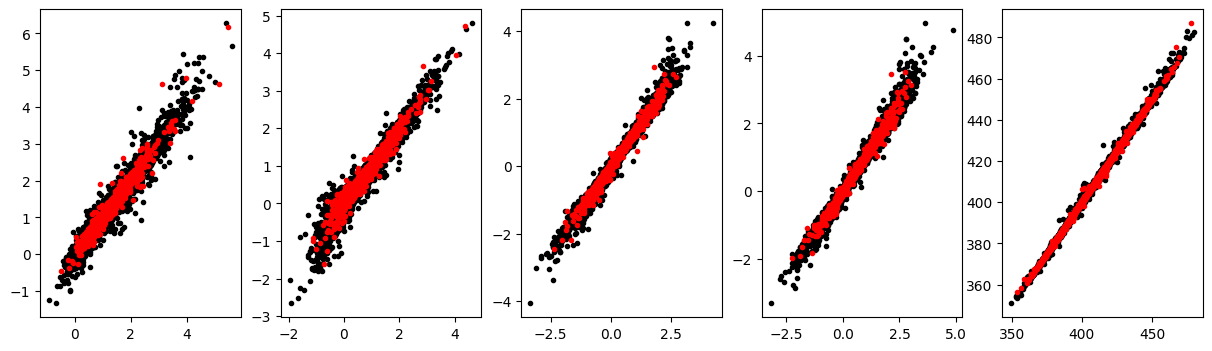

In [57]:
fig, ax = pl.subplots(1, nflds, figsize=(15, 4))


for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'k.')
  ax[i].plot(pred[:,i],YValidation[:,i],'r.')




In [ ]:
def log_prob(p,obs,obsunc,wgts):
    if len(p.shape)==1:
      p=p[np.newaxis,:]
    out=skillscore(dnn_model.predict(p,verbose = 0),obs,obsunc,wgts).T
    out[np.isnan(out)]=1e3
    return out

In [ ]:
!pip install emcee

In [ ]:
import numpy as np
import emcee


nw=100
ndim = df_configs.values.shape[1]
p0 = df_configs.values[:nw,:]
plt.hist(log_prob(p0,obs,obsunc))

In [ ]:
wgts1=[0,0,1,0,1]
wgts2=[0,0,1,1,1]
wgts3=[1,1,1,1,1]

if 0
sampler1 = emcee.EnsembleSampler(nw, ndim, log_prob, args=(obs,obsunc,wgts1),vectorize=True)
sampler1.run_mcmc(p0, 20000,progress=True)
sampler2 = emcee.EnsembleSampler(nw, ndim, log_prob, args=(obs,obsunc,wgts2),vectorize=True)
sampler2.run_mcmc(p0, 20000,progress=True)
sampler3 = emcee.EnsembleSampler(nw, ndim, log_prob, args=(obs,obsunc,wgts3),vectorize=True)
sampler3.run_mcmc(p0, 20000,progress=True)


In [ ]:


  pickle.dump( sampler1, open( "/content/drive/MyDrive/faireei/sampler1.p", "wb" ) )
  pickle.dump( sampler2, open( "/content/drive/MyDrive/faireei/sampler2.p", "wb" ) )
  pickle.dump( sampler3, open( "/content/drive/MyDrive/faireei/sampler3.p", "wb" ) )




In [ ]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

In [ ]:
sampler.chain[:,:,:].shape

In [ ]:
plt.hist(log_prob(p0,obs,obsunc))
plt.xlim([-500,0])

In [ ]:
plt.hist(log_prob(flat_samples,obs,obsunc))

In [ ]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [ ]:
plt.hist(dnn_model.predict(flat_samples)[:,4])

In [ ]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

In [ ]:
fig, ax = pl.subplots(2, 4, figsize=(12, 6))

for i, scenario in enumerate(scenarios):
    for pp in ((0, 100), (5, 95), (16, 84)):
        ax[i // 4, i % 4].fill_between(
            f.timebounds,
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[0],
                axis=1,
            ),
            np.percentile(
                f.temperature.loc[dict(scenario=scenario, layer=0)]
                - np.average(
                    f.temperature.loc[
                        dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                    ],
                    weights=weights_51yr,
                    axis=0
                ),
                pp[1],
                axis=1,
            ),
            color=ar6_colors[scenarios[i]],
            alpha=0.2,
            lw=0
        )

    ax[i // 4, i % 4].plot(
        f.timebounds,
        np.median(
            f.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                weights=weights_51yr,
                axis=0
            ),
            axis=1,
        ),
        color=ar6_colors[scenarios[i]],
    )
#     ax[i // 4, i % 4].plot(np.arange(1850.5, 2021), gmst, color="k")
    ax[i // 4, i % 4].set_xlim(1850, 2300)
    ax[i // 4, i % 4].set_ylim(-1, 10)
    ax[i // 4, i % 4].axhline(0, color="k", ls=":", lw=0.5)
    ax[i // 4, i % 4].set_title(fancy_titles[scenarios[i]])

pl.suptitle("SSP temperature anomalies")
fig.tight_layout()